Energy Disaggregation using Neural Networks
=======================================

In [1]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional
from keras import regularizers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
import scipy.io as sio

Using TensorFlow backend.


In [2]:
from keras.layers.normalization import BatchNormalization

The following functions are used to extract the time and day information from a timestamp value.

The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [3]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [4]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


The following function plots the losses against the epochs.

In [5]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

Data Preprocessing for ECO - Summer
------------------------------

The following function takes as input the file path, the channel index and the quantity name as input and loads the appropriate data files. It then joins themains and the output quantity based on the timestamp values, extracts time features from the timestamp and splits the input and output into two arrays.

In [6]:
from os import walk
path = "C:/Users/ghoshp/Downloads/IE594964/IE594964/REP594965/04_sm_csv/04_sm_csv/04"
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break

In [7]:
df={}
for filename in f:
    datestamp = filename[:-4].replace("-","")
    #print(datestamp)
    #if int(datestamp) >= 20120715 and int(datestamp) <= 20120825:
    df[datestamp]=pd.read_csv(path+"/"+filename,header=None,names=["powerallphases","powerl1","powerl2","powerl3","currentneutral","currentl1","currentl2",
                                    "currentl3","voltagel1","voltagel2","voltagel3","phaseanglevoltagel2l1",
                                    "phaseanglevoltagel3l1","phaseanglecurrentvoltagel1","phaseanglecurrentvoltagel2",
                                    "phaseanglecurrentvoltagel3"])
len(df)

219

In [8]:
df2 = pd.read_csv("C:/Users/ghoshp/Downloads/IE594964/IE594964/REP594965/04_occupancy_csv/04_winter.csv",index_col=0)
df2.index = pd.to_datetime(df2.index)
df2.index = df2.index.strftime('%Y%m%d')
len(df2)

48

In [9]:
import datetime
summer = df2.index.tolist()
# for i in range(len(summer)):
#     item = pd.to_datetime(summer[i])
#     item = item.strftime('%Y%m%d')
#     summer[i] = item
df_summer = {}
for key in df.keys():
    if key in summer:
        df_summer[key]=df[key]
len(df_summer)
#df_summer["20120730"]

48

In [12]:
n = 900  #chunk row size
summer_features = pd.DataFrame()
for day, data in df_summer.items():
    list_df_summer = [data[i:i+n] for i in range(0,len(data),n)]
    mean123 = []
    mean1 = []
    mean2 = []
    mean3 = []
    std123 = []
    std1 = []
    std2 = []
    std3 = []
    sad1 = []
    sad2 = []
    sad3 = []
    sad123 = []
    range1 = []
    range2 = []
    range3 = []
    range123 = []
    max123 = []
    max1 = []
    max2 = []
    max3 = []
    min123 = []
    min1 = []
    min2 = []
    min3 = []
    corr123 = []
    corr1 = []
    corr2 = []
    corr3 = []
    onoff123 = []
    onoff1 = []
    onoff2 = []
    onoff3 = []
    
    for chunk in list_df_summer:
        mean123.append(np.mean(chunk['powerallphases']))
        mean1.append(np.mean(chunk['powerl1']))
        mean2.append(np.mean(chunk['powerl2']))
        mean3.append(np.mean(chunk['powerl3']))
        std123.append(np.std(chunk['powerallphases']))
        std1.append(np.std(chunk['powerl1']))
        std2.append(np.std(chunk['powerl2']))
        std3.append(np.std(chunk['powerl3']))
        range123.append(np.amax(chunk['powerallphases'] - np.amin(chunk['powerallphases'])))
        range1.append(np.amax(chunk['powerl1'] - np.amin(chunk['powerl1'])))
        range2.append(np.amax(chunk['powerl2'] - np.amin(chunk['powerl2'])))
        range3.append(np.amax(chunk['powerl3'] - np.amin(chunk['powerl3'])))
        sad123.append(calc_sad(chunk['powerallphases']))
        sad1.append(calc_sad(chunk['powerl1']))
        sad2.append(calc_sad(chunk['powerl2']))
        sad3.append(calc_sad(chunk['powerl3']))
        max123.append(np.amax(chunk['powerallphases']))
        max1.append(np.amax(chunk['powerl1']))
        max2.append(np.amax(chunk['powerl2']))
        max3.append(np.amax(chunk['powerl3']))
        min123.append(np.amin(chunk['powerallphases']))
        min1.append(np.amin(chunk['powerl1']))
        min2.append(np.amin(chunk['powerl2']))
        min3.append(np.amin(chunk['powerl3']))
        corr123.append(chunk['powerallphases'].autocorr(lag=1))
        corr1.append(chunk['powerl1'].autocorr(lag=1))
        corr2.append(chunk['powerl2'].autocorr(lag=1))
        corr3.append(chunk['powerl3'].autocorr(lag=1))
        onoff123.append(detect_onoff(chunk['powerallphases']))
        onoff1.append(detect_onoff(chunk['powerl1']))
        onoff2.append(detect_onoff(chunk['powerl2']))
        onoff3.append(detect_onoff(chunk['powerl3']))
    ptime = list(range(1,97))
    data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
                                            std1,std2,std3,std123,sad1,sad2,sad3,sad123,
                                         corr1,corr2,corr3,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,
                                         range3,range123,ptime)), 
                            columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])
    
#     data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
#                                             std1,std2,std3,std123,range1,range2,range3,range123,ptime)), 
#                             columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
#                                        'mean123','std1','std2','std3','std123',
#                                        'range1','range2','range3','range123','ptime'])
    
    summer_features = summer_features.append(data)
summer_features.loc[summer_features.ptime < 25, 'ptime'] = 0
summer_features.loc[summer_features.ptime > 89, 'ptime'] = 0
summer_features = summer_features.loc[(summer_features['ptime'] >0)]
summer_features['ptime'] = summer_features['ptime'] - 24

#         print(summer_features)
#        break

In [13]:
summer_features

,min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,...,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,range3,range123,ptime
24,308.469,0.000,415.600,729.656,1337.630,0.000,494.767,1760.480,390.920621,0.000000,...,0.631962,0.0,0.0,0.0,0.0,1029.161,0.000,79.167,1030.824,1.0
25,282.958,0.000,427.371,816.462,1869.550,0.000,2187.380,3677.300,436.666281,0.000000,...,0.958945,0.0,0.0,0.0,0.0,1586.592,0.000,1760.009,2860.838,2.0
26,287.565,0.000,442.495,748.570,510.321,0.000,2192.390,2495.520,323.185460,0.000000,...,0.912289,0.0,0.0,0.0,0.0,222.756,0.000,1749.895,1746.950,3.0
27,376.431,0.000,448.660,832.988,409.700,75.727,784.482,1250.800,391.106730,13.794213,...,0.995961,0.0,0.0,0.0,0.0,33.269,75.727,335.822,417.812,4.0
28,370.644,0.000,637.684,1018.290,393.745,0.000,816.644,1208.500,384.438228,0.000000,...,0.986234,0.0,0.0,0.0,0.0,23.101,0.000,178.960,190.210,5.0
29,364.366,0.000,519.283,884.804,1131.960,0.000,718.149,1746.970,395.223169,0.000000,...,0.926137,0.0,0.0,0.0,0.0,767.594,0.000,198.866,862.166,6.0
30,372.901,0.000,519.671,894.210,1306.410,0.000,657.266,1829.410,471.657789,0.000000,...,0.782825,0.0,0.0,0.0,0.0,933.509,0.000,137.595,935.200,7.0
31,379.198,0.000,56.991,519.436,499.466,0.000,537.416,1035.200,476.289479,0.000000,...,0.998638,0.0,0.0,0.0,0.0,120.268,0.000,480.425,515.764,8.0
32,353.595,0.000,56.418,410.454,404.451,0.000,160.612,564.812,381.377474,0.000000,...,0.992765,0.0,0.0,0.0,0.0,50.856,0.000,104.194,154.358,9.0
33,305.268,0.000,56.560,362.307,1900.590,0.000,96.168,1990.340,669.752309,0.000000,...,0.974829,0.0,0.0,0.0,0.0,1595.322,0.000,39.608,1628.033,10.0


In [14]:
n = 900

cuml_list = []
for index,row in df2.iterrows():
    occ_summer = []
    list_oc_summer = [row[i:i+n] for i in range(0,len(row),n)]
    for chunk in list_oc_summer:
        occ_summer.append(np.bincount(chunk).argmax())
    occ_summer = occ_summer[24:89]
#     print(len(occ_summer))
    cuml_list.extend(occ_summer)
#     print(len(cuml_list))
occ_summer_data = pd.DataFrame(cuml_list, columns = ['occupancy'])
# print(occ_summer_data)    
#     print(len(list_oc_summer))
#     if row[0] > '06:00:00':
#         print(row[1])
    

In [15]:
occ_summer_data

,occupancy
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [10]:
def calc_sad(X):
    sad = 0
#     print(X)
#     print('end of X')
    for i in X.index.tolist():
#         print(i)
        if i < X.last_valid_index():
            sad += abs(X[i] - X[i+1])
    return sad

In [11]:
def detect_onoff(X):
    on_off = 0
    thA = 30
    thT = 30
    timecount = 0
    for i in X.index.tolist():
        if i < X.last_valid_index():
#             print(timecount)
            if abs(X[i] - X[i+1]) >= thA:
                timecount += 1
            else:
                timecount = 0
            if timecount == thT:
                on_off += 1
                timecount = 0
    return on_off

Standardizing data
================

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(summer_features)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [42]:
summer_std = scaler.transform(summer_features)

In [43]:
summer_std[np.isnan(summer_std)] = 0

PCA
====

In [44]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.99)

In [45]:
pca.fit(summer_std)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [46]:
pca.n_components_

18

In [47]:
summer_pca = pca.transform(summer_std)

In [48]:
summer_pca.shape

(3120, 18)

Training and Testing
-------------------------------

The model is trained on the"dishwasher" appliance for house 1. The training set comprises 20000 samples and the testing set comprises 2000 samples. The loss curve is plotted. he predicted values are also plotted against the actual values forthe test set.

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(summer_pca, occ_summer_data, test_size=0.15,shuffle=True)

In [75]:
X_train.shape

(2652, 18)

Model Specification
-------------------------------
The following function is used to create the model.

In [26]:
def init_model():
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(18,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
#     model.add(Bidirectional(LSTM(128, return_sequences=True,
#                                   stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.25))
#     model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.2))
#     model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

In [27]:
def create_seq(X):
    res = []
    rem = X.shape[0] % 4
    for i in range(0,X.shape[0],4):
#         print(i)
        if  (i+4) > X.shape[0]:
            balc = X.shape[0] - i
            res.append(np.concatenate((X[i:i+balc,:],np.zeros((i+4 - X.shape[0],X.shape[1])))))
        else:
            res.append(X[i:i+4,:])
    res = np.array(res)
#     print(len(res))
    return res
   

W0830 01:45:10.820335 17468 deprecation_wrapper.py:119] From C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 01:45:10.840322 17468 deprecation_wrapper.py:119] From C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 01:45:10.842321 17468 deprecation_wrapper.py:119] From C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 01:45:10.916275 17468 deprecation_wrapper.py:119] From C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Pleas

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 18, 256)           1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 256)           1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 128)           131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 128)           512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 18, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 18, 64)            32832     
__________

2652/2652 [==============================] - 2s 731us/step - loss: 0.1649 - acc: 0.9272 - val_loss: 0.2029 - val_acc: 0.9124
Epoch 39/200
2652/2652 [==============================] - 2s 745us/step - loss: 0.1597 - acc: 0.9299 - val_loss: 0.2057 - val_acc: 0.9145
Epoch 40/200
2652/2652 [==============================] - 2s 751us/step - loss: 0.1625 - acc: 0.9317 - val_loss: 0.2172 - val_acc: 0.9081
Epoch 41/200
2652/2652 [==============================] - 2s 715us/step - loss: 0.1567 - acc: 0.9261 - val_loss: 0.2313 - val_acc: 0.8974
Epoch 42/200
2652/2652 [==============================] - 2s 715us/step - loss: 0.1627 - acc: 0.9306 - val_loss: 0.2744 - val_acc: 0.8953
Epoch 43/200
2652/2652 [==============================] - 2s 714us/step - loss: 0.1531 - acc: 0.9302 - val_loss: 0.2660 - val_acc: 0.9017
Epoch 44/200
2652/2652 [==============================] - 2s 716us/step - loss: 0.1528 - acc: 0.9302 - val_loss: 0.2203 - val_acc: 0.9060
Epoch 45/200
2652/2652 [=======================

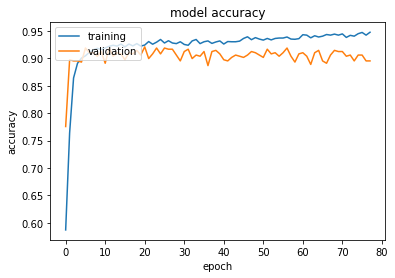

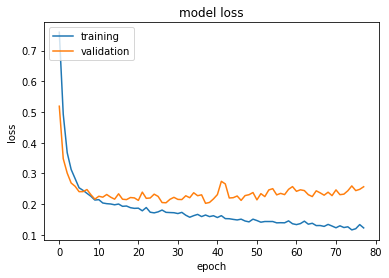

In [28]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
model = init_model()
model.summary()
# X_train = create_seq(X_train)
# y_train = create_seq(y_train.values)
# X_test = create_seq(X_test)
# y_test = create_seq(y_test.values)
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
history = model.fit(X_train, y_train, epochs=200, batch_size=32,validation_data=(X_test,y_test),callbacks=[es])
score = model.evaluate(X_test, y_test, batch_size=32)
print(score)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

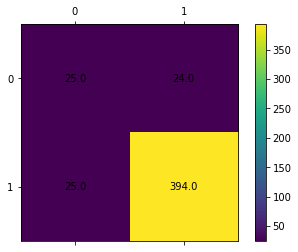

In [29]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
cm = confusion_matrix(y_test, y_pred)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cm)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()


K-fold Cross Validation
----------------------

In [30]:
from sklearn.model_selection import StratifiedKFold

In [31]:
Xs=summer_pca
ys=occ_summer_data.values

446/446 [==============================] - 0s 209us/step


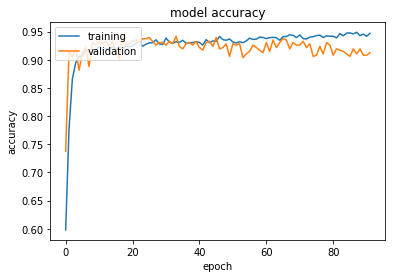

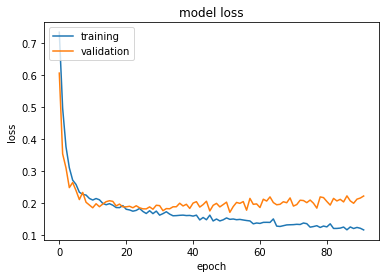

acc: 91.26%
loss: 0.22%
446/446 [==============================] - 0s 207us/step


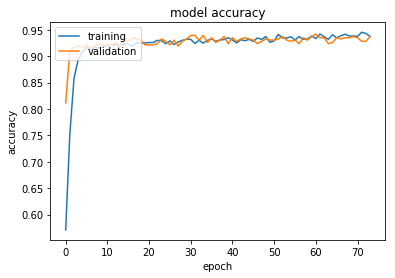

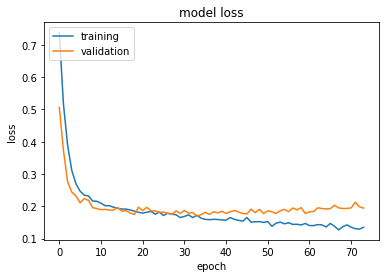

acc: 93.72%
loss: 0.19%
446/446 [==============================] - 0s 214us/step


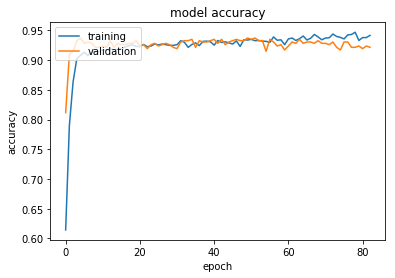

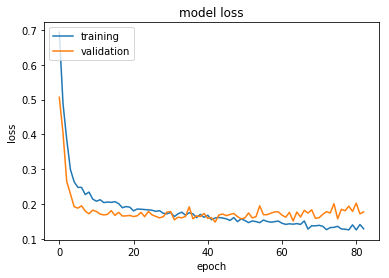

acc: 92.15%
loss: 0.18%
446/446 [==============================] - 0s 206us/step


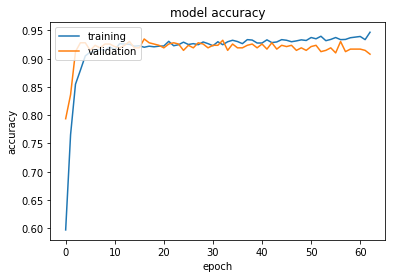

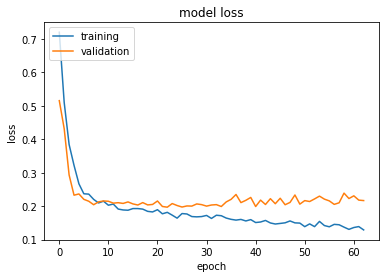

acc: 90.81%
loss: 0.22%
446/446 [==============================] - 0s 240us/step


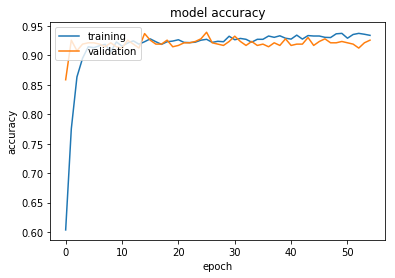

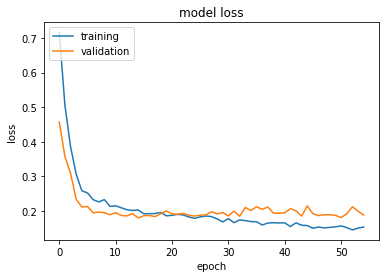

acc: 92.60%
loss: 0.19%
446/446 [==============================] - 0s 253us/step


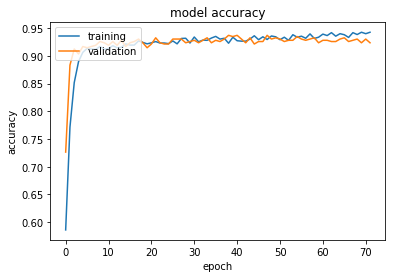

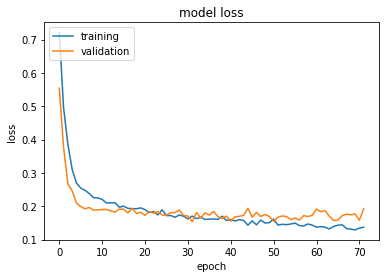

acc: 92.38%
loss: 0.19%
444/444 [==============================] - 0s 236us/step


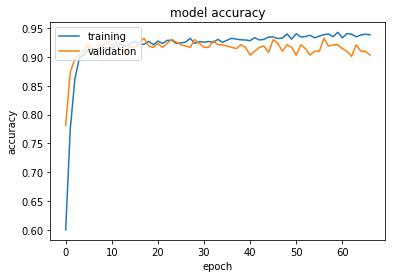

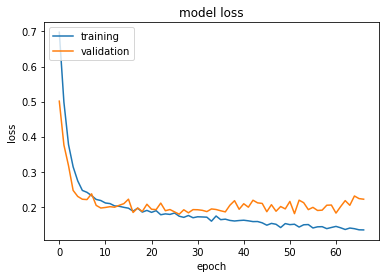

acc: 90.32%
loss: 0.22%
91.89% (+/- 1.08%)


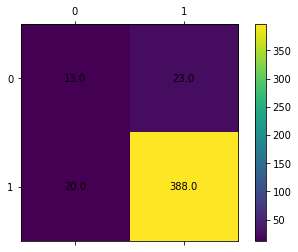

In [32]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvsloss = []
cvscm = []
for train, test in kfold.split(Xs, ys):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = Xs[train].reshape(Xs[train].shape[0], Xs[train].shape[1],1)
    X_test = Xs[test].reshape(Xs[test].shape[0], Xs[test].shape[1],1)
    model = init_model()
    # X_train = create_seq(X_train)
    # y_train = create_seq(y_train.values)
    # X_test = create_seq(X_test)
    # y_test = create_seq(y_test.values)
    es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=40)
    history = model.fit(X_train, ys[train], epochs=200, batch_size=32,validation_data=(X_test,ys[test]),callbacks=[es],verbose=0)
    scores = model.evaluate(X_test, ys[test], batch_size=32)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]))
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(ys[test], y_pred)
    cvscores.append(scores[1] * 100)
    cvsloss.append(scores[0])
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

PCA + SVM
=============

In [76]:
from sklearn.svm import SVC
svclassifier = SVC()
svclassifier.fit(X_train, y_train)

C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [77]:
y_pred = svclassifier.predict(X_test)

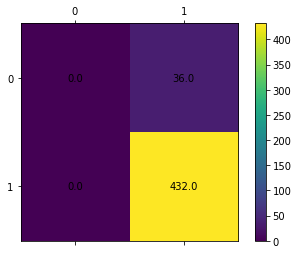

In [78]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
cm = confusion_matrix(y_test, y_pred)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cm)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()


In [79]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9230769230769231


K-fold
---------------

In [80]:
from sklearn.model_selection import StratifiedKFold

In [81]:
Xs=summer_pca
ys=occ_summer_data.values

C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.70%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.70%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.70%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.70%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.70%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.70%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.89%
91.73% (+/- 0.07%)


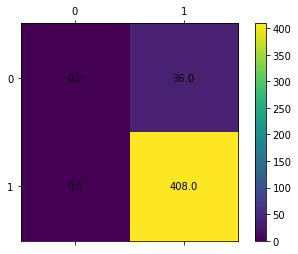

In [82]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(Xs, ys):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = Xs[train]
    X_test = Xs[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, ys[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(ys[test], y_pred)
    acc = accuracy_score(ys[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

Naked NN
================

In [33]:
def init_model(features):
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(features,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

In [34]:
# X = np.array(summer_features)
# print('X dim: ',X.shape)
# y = np.array(occ_summer_data)
# print('y dim: ',y.shape)

# X = normalize_data(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(summer_std, occ_summer_data.values, test_size=0.15, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('X_train dim: ', X_train.shape)
print('X_test dim: ', X_test.shape)
print('y_train dim: ', y_train.shape)
print('y_test dim: ', y_test.shape)

X_train dim:  (2652, 33, 1)
X_test dim:  (468, 33, 1)
y_train dim:  (2652, 1)
y_test dim:  (468, 1)


In [35]:
features = X_train.shape[1]
model = init_model(features)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 33, 256)           1280      
_________________________________________________________________
batch_normalization_49 (Batc (None, 33, 256)           1024      
_________________________________________________________________
dropout_49 (Dropout)         (None, 33, 256)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 33, 128)           131200    
_________________________________________________________________
batch_normalization_50 (Batc (None, 33, 128)           512       
_________________________________________________________________
dropout_50 (Dropout)         (None, 33, 128)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 33, 64)            32832     
__________

Train on 2652 samples, validate on 468 samples
Epoch 1/150
 - 8s - loss: 0.7148 - acc: 0.6112 - val_loss: 0.5910 - val_acc: 0.7308
Epoch 2/150
 - 4s - loss: 0.4787 - acc: 0.7930 - val_loss: 0.3765 - val_acc: 0.8825
Epoch 3/150
 - 4s - loss: 0.3580 - acc: 0.8737 - val_loss: 0.2744 - val_acc: 0.9038
Epoch 4/150
 - 4s - loss: 0.3025 - acc: 0.8974 - val_loss: 0.2962 - val_acc: 0.8889
Epoch 5/150
 - 4s - loss: 0.2648 - acc: 0.9091 - val_loss: 0.2545 - val_acc: 0.8996
Epoch 6/150
 - 4s - loss: 0.2557 - acc: 0.9091 - val_loss: 0.2577 - val_acc: 0.8996
Epoch 7/150
 - 4s - loss: 0.2312 - acc: 0.9133 - val_loss: 0.2231 - val_acc: 0.9124
Epoch 8/150
 - 4s - loss: 0.2275 - acc: 0.9144 - val_loss: 0.2689 - val_acc: 0.8932
Epoch 9/150
 - 4s - loss: 0.2200 - acc: 0.9193 - val_loss: 0.2287 - val_acc: 0.9017
Epoch 10/150
 - 4s - loss: 0.2053 - acc: 0.9250 - val_loss: 0.2384 - val_acc: 0.9060
Epoch 11/150
 - 4s - loss: 0.2021 - acc: 0.9208 - val_loss: 0.2383 - val_acc: 0.9081
Epoch 12/150
 - 4s - loss: 

Epoch 97/150
 - 4s - loss: 0.0843 - acc: 0.9627 - val_loss: 0.2495 - val_acc: 0.9103
Epoch 98/150
 - 4s - loss: 0.1065 - acc: 0.9544 - val_loss: 0.2418 - val_acc: 0.9124
Epoch 99/150
 - 4s - loss: 0.0923 - acc: 0.9608 - val_loss: 0.2837 - val_acc: 0.9103
Epoch 100/150
 - 4s - loss: 0.0902 - acc: 0.9619 - val_loss: 0.2837 - val_acc: 0.9188
Epoch 101/150
 - 4s - loss: 0.1025 - acc: 0.9529 - val_loss: 0.2412 - val_acc: 0.9188
Epoch 102/150
 - 4s - loss: 0.0949 - acc: 0.9627 - val_loss: 0.2845 - val_acc: 0.9060
Epoch 103/150
 - 4s - loss: 0.1042 - acc: 0.9548 - val_loss: 0.2700 - val_acc: 0.9145
Epoch 104/150
 - 4s - loss: 0.0906 - acc: 0.9593 - val_loss: 0.2952 - val_acc: 0.9145
Epoch 00104: early stopping
468/468 [==============================] - 0s 411us/step
loss and accuracy::  [0.2951996193991767, 0.9145299145299145]


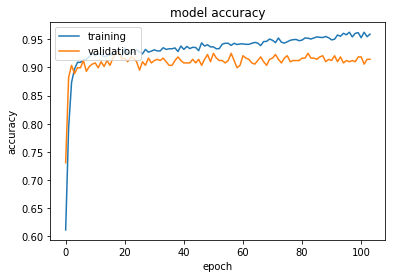

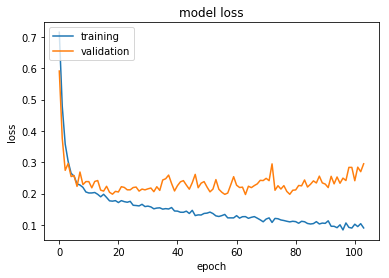

In [36]:
# history = LossHistory()
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[es],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score)

plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

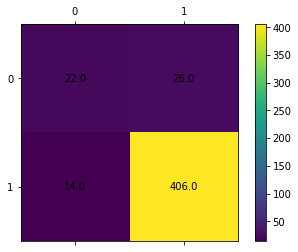

In [37]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()

conf_matrix(X_test,y_test)

K-fold Validation 
=================

In [38]:
from sklearn.model_selection import StratifiedKFold

In [39]:
Xs=summer_std
ys=occ_summer_data.values

446/446 [==============================] - 0s 413us/step


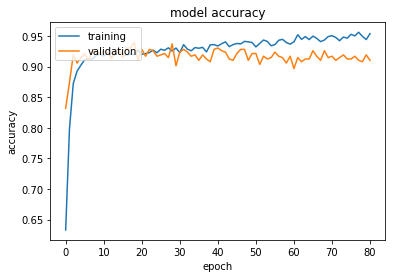

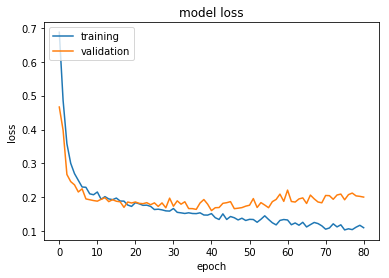

acc: 91.03%
loss: 0.20%
446/446 [==============================] - 0s 445us/step


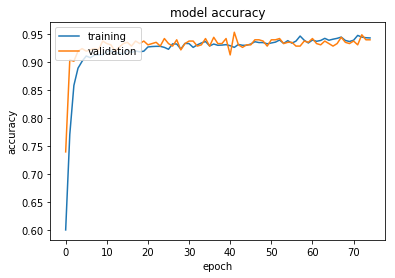

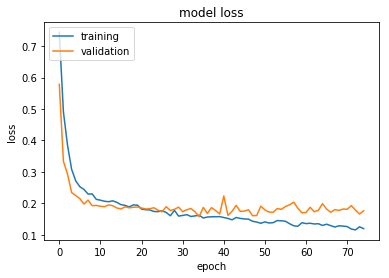

acc: 93.95%
loss: 0.18%
446/446 [==============================] - 0s 497us/step


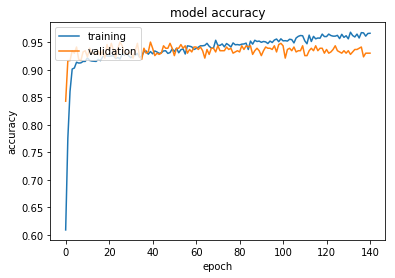

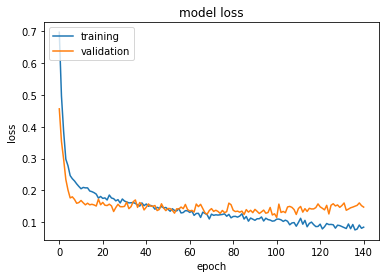

acc: 93.05%
loss: 0.15%
446/446 [==============================] - 0s 509us/step


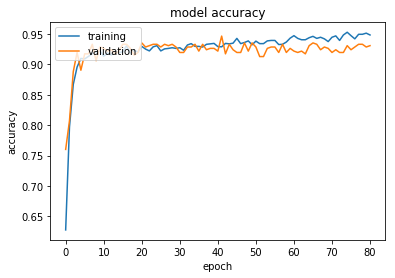

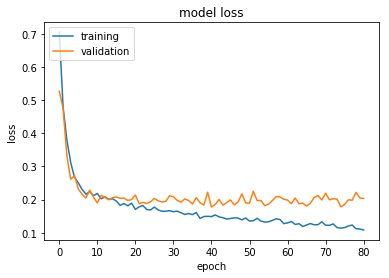

acc: 93.05%
loss: 0.20%
446/446 [==============================] - 0s 504us/step


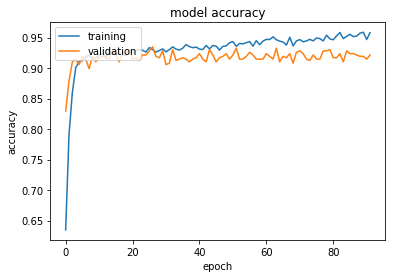

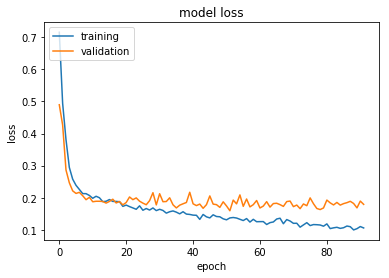

acc: 92.15%
loss: 0.18%
446/446 [==============================] - 0s 515us/step


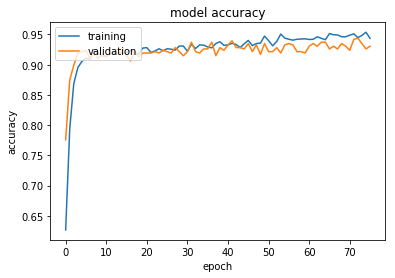

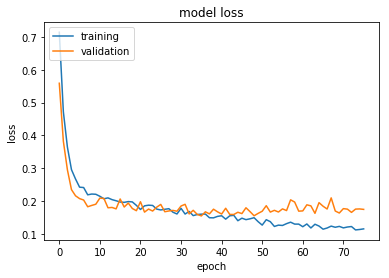

acc: 93.05%
loss: 0.17%
444/444 [==============================] - 0s 580us/step


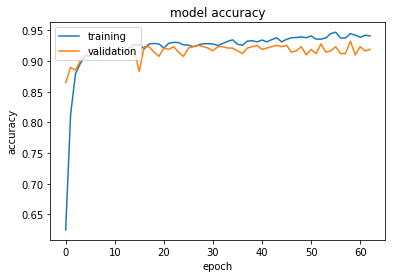

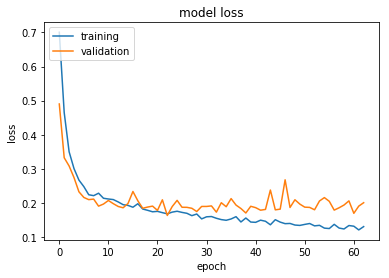

acc: 91.89%
loss: 0.20%
92.60% (+/- 0.89%)


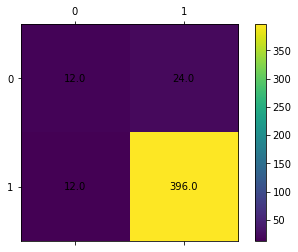

In [40]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvsloss = []
cvscm = []
for train, test in kfold.split(Xs, ys):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = Xs[train].reshape(Xs[train].shape[0], Xs[train].shape[1],1)
    X_test = Xs[test].reshape(Xs[test].shape[0], Xs[test].shape[1],1)
    features = X_train.shape[1]
    model = init_model(features)
    # X_train = create_seq(X_train)
    # y_train = create_seq(y_train.values)
    # X_test = create_seq(X_test)
    # y_test = create_seq(y_test.values)
    es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=40)
    history = model.fit(X_train, ys[train], epochs=200, batch_size=32,validation_data=(X_test,ys[test]),callbacks=[es],verbose=0)
    scores = model.evaluate(X_test, ys[test], batch_size=32)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]))
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(ys[test], y_pred)
    cvscores.append(scores[1] * 100)
    cvsloss.append(scores[0])
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

Shapely Values
===============

In [49]:
# X = np.array(summer_features)
# print('X dim: ',X.shape)
# y = np.array(occ_summer_data)
# print('y dim: ',y.shape)

# X = normalize_data(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(summer_std, occ_summer_data.values, test_size=0.15, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('X_train dim: ', X_train.shape)
print('X_test dim: ', X_test.shape)
print('y_train dim: ', y_train.shape)
print('y_test dim: ', y_test.shape)

X_train dim:  (2652, 33, 1)
X_test dim:  (468, 33, 1)
y_train dim:  (2652, 1)
y_test dim:  (468, 1)


In [50]:
import shap

# select a set of background examples to take an expectation over
background = X_train
X_train.shape

(2652, 33, 1)

In [51]:
def init_model(features):
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(features,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

In [52]:
features = X_train.shape[1]
model = init_model(features)
model.summary()
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
shap_values = e.shap_values(X_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 33, 256)           1280      
_________________________________________________________________
batch_normalization_97 (Batc (None, 33, 256)           1024      
_________________________________________________________________
dropout_97 (Dropout)         (None, 33, 256)           0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 33, 128)           131200    
_________________________________________________________________
batch_normalization_98 (Batc (None, 33, 128)           512       
_________________________________________________________________
dropout_98 (Dropout)         (None, 33, 128)           0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 33, 64)            32832     
__________

In [53]:
shap_values[0]= shap_values[0].reshape(shap_values[0].shape[0],shap_values[0].shape[1])
shap_values[0].shape

X_postprocess = X_train.reshape(X_train.shape[0],X_train.shape[1])
X_postprocess.shape

(2652, 33)

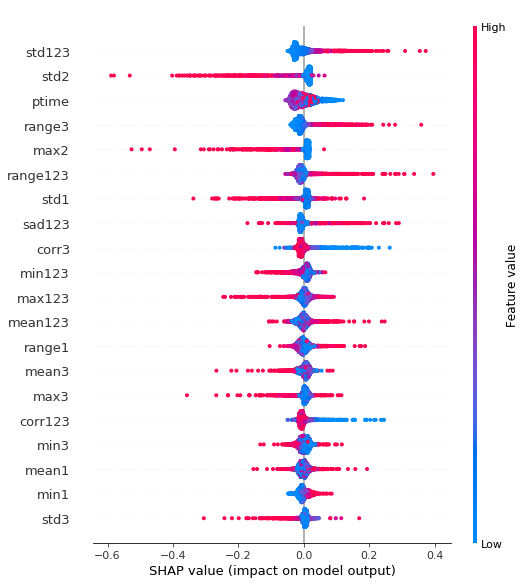

In [54]:
shap.summary_plot(shap_values[0], X_postprocess, feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

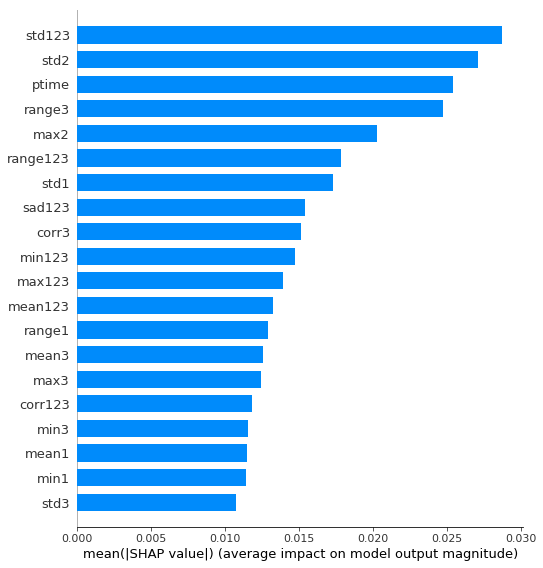

In [55]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar", feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

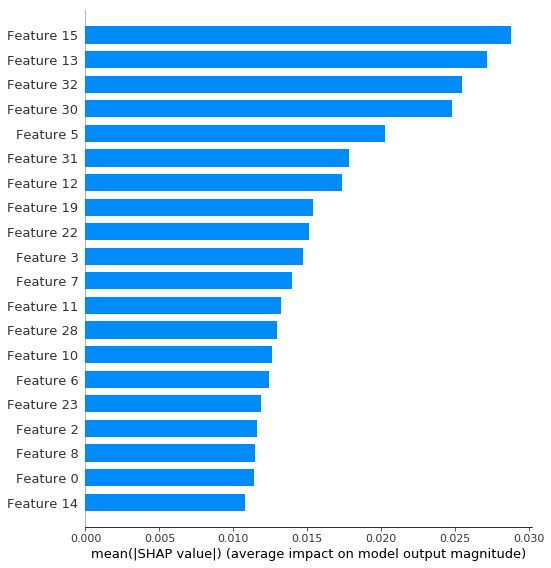

In [56]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar")

After Feature Reduction by Shapely
======================

In [57]:
new_summer_features= summer_std[:,0:1]
new_summer_features = np.concatenate((new_summer_features, summer_std[:,2:4], summer_std[:,5:9],summer_std[:,10:16],
                                     summer_std[:,19:20],summer_std[:,22:24],summer_std[:,28:29],summer_std[:,30:33]),axis=1)
new_summer_features.shape


(3120, 20)

In [58]:
# X_train1 =new_summer_features[0:2200,:]
# X_test1 = new_summer_features[2200:2535,:]

from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(new_summer_features, occ_summer_data.values, test_size=0.15, shuffle=True)

X_train1 = X_train1.reshape(X_train1.shape[0], X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0], X_test1.shape[1], 1)
X_test1.shape

(468, 20, 1)

In [59]:
model = init_model(X_train1.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 20, 256)           1280      
_________________________________________________________________
batch_normalization_103 (Bat (None, 20, 256)           1024      
_________________________________________________________________
dropout_103 (Dropout)        (None, 20, 256)           0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 20, 128)           131200    
_________________________________________________________________
batch_normalization_104 (Bat (None, 20, 128)           512       
_________________________________________________________________
dropout_104 (Dropout)        (None, 20, 128)           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 20, 64)            32832     
__________

Train on 2652 samples, validate on 468 samples
Epoch 1/200
 - 11s - loss: 0.7423 - acc: 0.6195 - val_loss: 0.4921 - val_acc: 0.8376
Epoch 2/200
 - 4s - loss: 0.4824 - acc: 0.7866 - val_loss: 0.3415 - val_acc: 0.9017
Epoch 3/200
 - 4s - loss: 0.3631 - acc: 0.8684 - val_loss: 0.2868 - val_acc: 0.9167
Epoch 4/200
 - 4s - loss: 0.3039 - acc: 0.8982 - val_loss: 0.2341 - val_acc: 0.9124
Epoch 5/200
 - 4s - loss: 0.2739 - acc: 0.9005 - val_loss: 0.2298 - val_acc: 0.9103
Epoch 6/200
 - 4s - loss: 0.2510 - acc: 0.9095 - val_loss: 0.2189 - val_acc: 0.9316
Epoch 7/200
 - 4s - loss: 0.2384 - acc: 0.9163 - val_loss: 0.2103 - val_acc: 0.9231
Epoch 8/200
 - 4s - loss: 0.2361 - acc: 0.9084 - val_loss: 0.2084 - val_acc: 0.9103
Epoch 9/200
 - 4s - loss: 0.2148 - acc: 0.9208 - val_loss: 0.2063 - val_acc: 0.9124
Epoch 10/200
 - 4s - loss: 0.2157 - acc: 0.9163 - val_loss: 0.2072 - val_acc: 0.9060
Epoch 11/200
 - 4s - loss: 0.2077 - acc: 0.9186 - val_loss: 0.1898 - val_acc: 0.9252
Epoch 12/200
 - 4s - loss:

Epoch 97/200
 - 4s - loss: 0.1075 - acc: 0.9510 - val_loss: 0.1667 - val_acc: 0.9295
Epoch 98/200
 - 4s - loss: 0.1041 - acc: 0.9498 - val_loss: 0.1606 - val_acc: 0.9295
Epoch 99/200
 - 4s - loss: 0.1178 - acc: 0.9427 - val_loss: 0.1853 - val_acc: 0.9274
Epoch 100/200
 - 4s - loss: 0.1191 - acc: 0.9419 - val_loss: 0.1671 - val_acc: 0.9380
Epoch 101/200
 - 4s - loss: 0.1062 - acc: 0.9487 - val_loss: 0.1577 - val_acc: 0.9380
Epoch 102/200
 - 4s - loss: 0.1022 - acc: 0.9540 - val_loss: 0.1611 - val_acc: 0.9316
Epoch 103/200
 - 4s - loss: 0.1144 - acc: 0.9457 - val_loss: 0.1653 - val_acc: 0.9316
Epoch 00103: early stopping
468/468 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 643us/step
[0.1653338146642742, 0.9316239311144903]


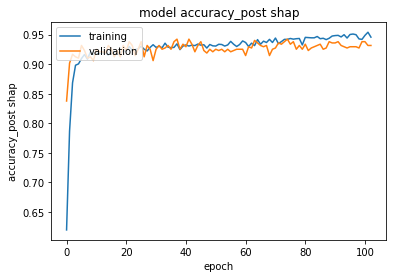

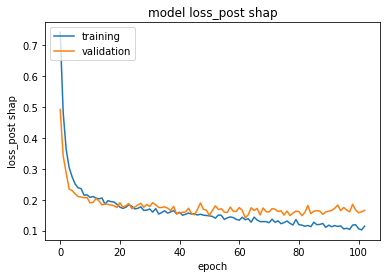

In [60]:
# history1 = LossHistory()
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss1 = model.fit(X_train1, y_train1, epochs=200, batch_size=32,
                callbacks=[es],
                validation_data=(X_test1,y_test1), verbose=2)
score1 = model.evaluate(X_test1, y_test1, batch_size=64)
print(score1)
plt.plot(hiss1.history['acc'])
plt.plot(hiss1.history['val_acc'])
plt.title('model accuracy_post shap')
plt.ylabel('accuracy_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss1.history['loss'])
plt.plot(hiss1.history['val_loss'])
plt.title('model loss_post shap')
plt.ylabel('loss_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

y_pred = model.predict(X_test1)

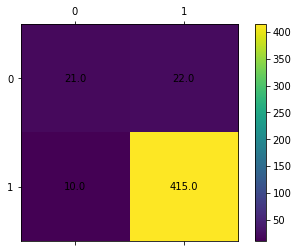

In [61]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()

conf_matrix(X_test1,y_test1)

K-fold Validation 
=================

In [62]:
from sklearn.model_selection import StratifiedKFold

In [63]:
Xs=new_summer_features
ys=occ_summer_data.values

446/446 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 510us/step


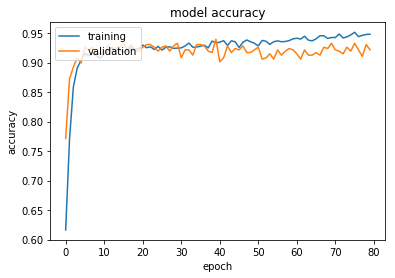

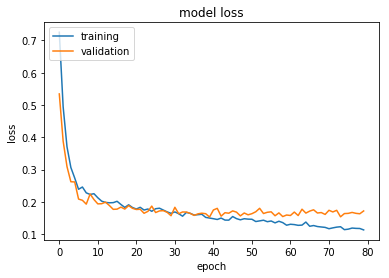

acc: 92.15%
loss: 0.17%
446/446 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 707us/step


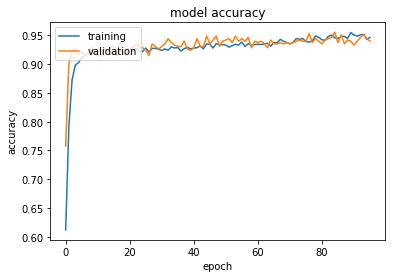

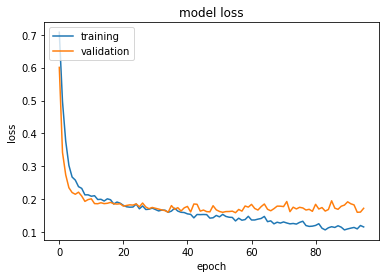

acc: 93.95%
loss: 0.17%
446/446 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 649us/step


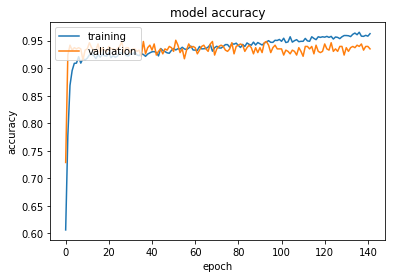

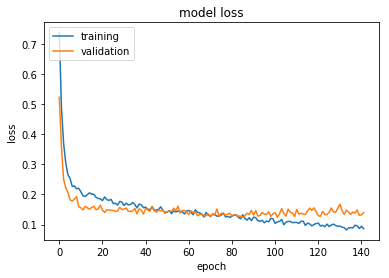

acc: 93.50%
loss: 0.14%
446/446 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 767us/step


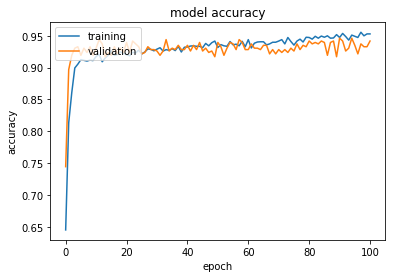

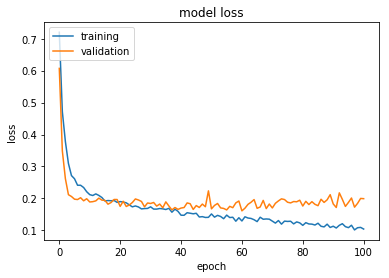

acc: 94.17%
loss: 0.20%
446/446 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 781us/step


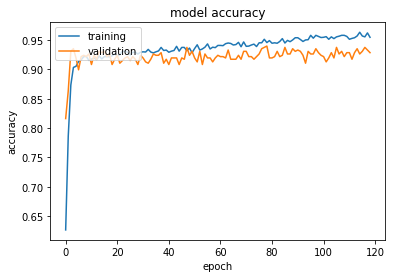

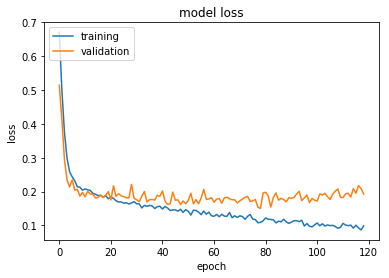

acc: 92.83%
loss: 0.19%
446/446 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 858us/step


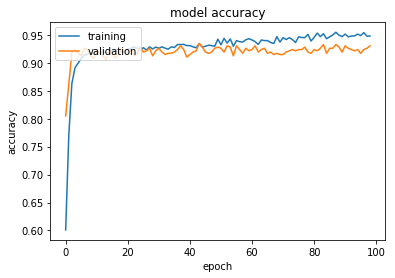

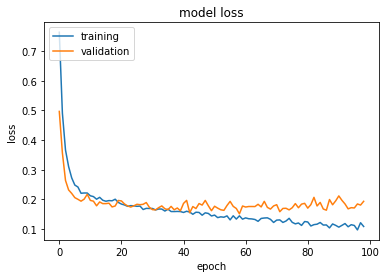

acc: 93.05%
loss: 0.19%
444/444 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 943us/step


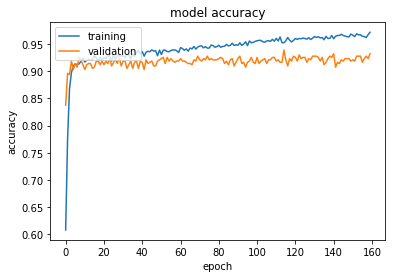

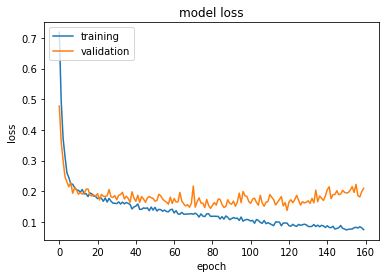

acc: 93.24%
loss: 0.21%
93.27% (+/- 0.63%)


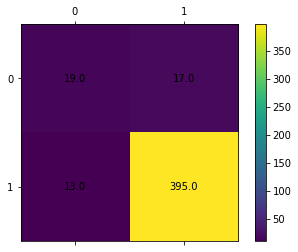

In [64]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvsloss = []
cvscm = []
for train, test in kfold.split(Xs, ys):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = Xs[train].reshape(Xs[train].shape[0], Xs[train].shape[1],1)
    X_test = Xs[test].reshape(Xs[test].shape[0], Xs[test].shape[1],1)
    features = X_train.shape[1]
    model = init_model(features)
    # X_train = create_seq(X_train)
    # y_train = create_seq(y_train.values)
    # X_test = create_seq(X_test)
    # y_test = create_seq(y_test.values)
    es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=40)
    history = model.fit(X_train, ys[train], epochs=200, batch_size=32,validation_data=(X_test,ys[test]),callbacks=[es],verbose=0)
    scores = model.evaluate(X_test, ys[test], batch_size=32)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]))
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(ys[test], y_pred)
    cvscores.append(scores[1] * 100)
    cvsloss.append(scores[0])
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

Shapely + SVM
==============

In [65]:
# X_train1 =new_summer_features[0:2200,:]
# X_test1 = new_summer_features[2200:2535,:]

from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(new_summer_features, occ_summer_data.values, test_size=0.15, shuffle=True)

# X_train1 = X_train1.reshape(X_train1.shape[0], X_train1.shape[1], 1)
# X_test1 = X_test1.reshape(X_test1.shape[0], X_test1.shape[1], 1)
X_test1.shape

(468, 20)

In [66]:
from sklearn.svm import SVC
svclassifier = SVC()
svclassifier.fit(X_train1, y_train1)

C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [67]:
y_pred = svclassifier.predict(X_test1)

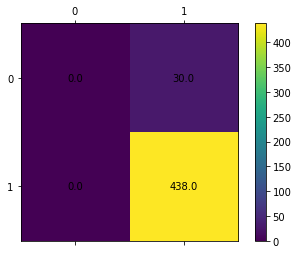

In [68]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
cm = confusion_matrix(y_test, y_pred)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cm)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()


In [69]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test1, y_pred))

0.9337606837606838


K-fold
--------------

In [70]:
from sklearn.model_selection import StratifiedKFold

In [71]:
Xs=new_summer_features
ys=occ_summer_data.values

C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.70%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.70%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.70%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.70%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.70%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.70%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.89%
91.73% (+/- 0.07%)


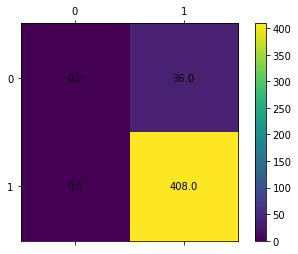

In [72]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(Xs, ys):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = Xs[train]
    X_test = Xs[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, ys[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(ys[test], y_pred)
    acc = accuracy_score(ys[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()